### Import packages

In [1]:
# Package(s) related to time, space and id
import datetime, time
import platform
import random
import os

# You need these dependencies (you can get these from anaconda)
# package(s) related to the simulation
import simpy

# Spatial libraries 
import pyproj
import shapely.geometry
from simplekml import Kml, Style

# Package(s) for data handling
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation

# Tranport network analysis package
import transport_network_analysis.core as core
import transport_network_analysis.graph_module as graph_module
import transport_network_analysis.model as model

# Used for mathematical functions
import math             
from numpy.random import choice

# Used for making the graph to visualize our problem
import networkx as nx  

### Import data for stations and transport lines

In [2]:
# Import stations and lines from csv 
df1 = pd.read_csv("Data/stations.csv", sep=";")
df2 = pd.read_csv("Data/lijnen.csv", sep=";")

# Convert columns to lst type\
from ast import literal_eval
df2.loc[:,'Route1'] = df2.loc[:,'Route1'].apply(lambda x: literal_eval(x))
df2.loc[:,'Route2'] = df2.loc[:,'Route2'].apply(lambda x: literal_eval(x))
df2.loc[:,'Duration'] = df2.loc[:,'Duration'].apply(lambda x: literal_eval(x)) 
df1.loc[:,'HalteLon'] = df1.loc[:,'HalteLon'].apply(lambda x: float(str(x).replace(',','.')))
df1.loc[:,'HalteLat'] = df1.loc[:,'HalteLat'].apply(lambda x: float(str(x).replace(',','.')))

In [3]:
# Create dictionary for all transport lines
lines = {}
durations = []

for index, row in df2.iterrows():
    lines[row["Line"]] = (row["Route1"], row["Route2"], row["Duration"])
    
edges = []
for k, v in lines.items():
    for x in range(len(v[0])):
        try:
            edges.append((v[0][x], v[0][x + 1], k, v[2][x]))
            edges.append((v[0][x + 1], v[0][x], k, v[2][x]))
        except:
            break

### Create graph

In [4]:
# Create graph
FG = nx.DiGraph()

# Create all stations and nodes
Node = type('Station', (core.Identifiable, core.Log, core.Locatable, core.HasResource, core.Station), {})
nodes = []
stations = []

for index, row in df1.iterrows():
    stations.append({"env": [],
                     "name": row["HalteNaam"],
                     "geometry": shapely.geometry.Point(row["HalteLat"], row["HalteLon"]),
                     "capacity": row["Capacity"]}) 

for station in stations:
    node = Node(**station)
    nodes.append(node)

# Create positions and add nodes to graph with right position
positions = {}

for node in nodes:
    positions[node.name] = (node.geometry.y, node.geometry.x)
    FG.add_node(node.name, geometry = node.geometry, object_type = node)

# Create all edges
for edge in edges:
    FG.add_edge(edge[0], edge[1], line = edge[2], duration = edge[3])

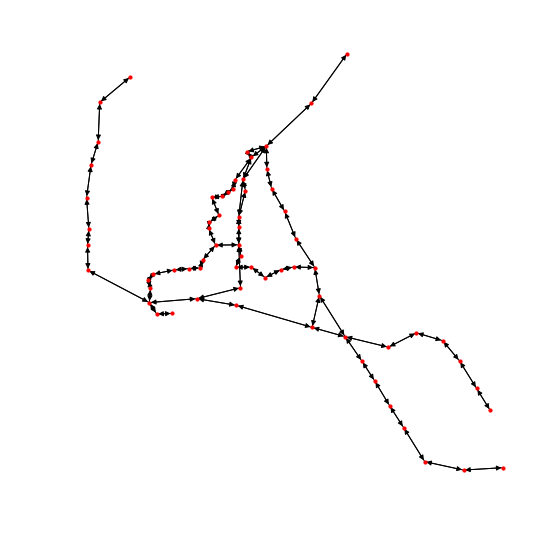

In [5]:
# Plot the network
plt.figure(figsize=(7,7)) 
# nx.draw(FG, positions, node_size=10, with_labels=True, font_size=10)
nx.draw(FG, positions, node_size=10)

### Route calculation and choice functions

In [6]:
# Calculate transfers and durations
def route_calculation(route, graph):
    route_info = {"lines": [], "duration": 0, "transfers": 0, "waiting": 0, "transferstations": []}
    
    for i in range(len(route) - 1):
        if route_info["lines"] != []:
            attr = FG.get_edge_data(route[i],route[i+1],default=0)
            if line != attr['line']:
                route_info["transfers"] += 1
                route_info["transferstations"].append(route[i])
                line = attr['line']
                route_info["lines"].append(line) 
        else:
            attr = FG.get_edge_data(route[i],route[i+1],default=0)
            line = attr['line']
            route_info["lines"].append(line) 

        route_info["duration"] += attr['duration']
        
    route_info["waiting"] = int(random.random() * 10)
    route_info["duration"] += (route_info["transfers"] * 3)
    
    return route_info

In [7]:
def route_choice(routes, classname):
    if classname == 0:
        minimum = routes[0][0]["duration"]
        index = 0
        for i in range(1, len(routes)):
            # Loop through all routes and save the route with the shortest trip duration
            if routes[i][0]["duration"] < minimum:
                minimum = routes[i][0]["duration"]
                index = i

            # If the duration is the same, save the route with the least waiting time
            elif routes[i][0]["duration"] == minimum:
                if routes[i][0]["transfers"] < routes[index][0]["transfers"]:
                    index = i

    elif classname == 1:
        minimum = routes[0][0]["waiting"]
        index = 0
        for i in range(1, len(routes)):
            # Loop through all routes and save the route with the least waiting time
            if routes[i][0]["waiting"] < minimum:
                minimum = routes[i][0]["waiting"]
                index = i

            # If waiting time is the same, save the route with the shortest duration
            elif routes[i][0]["waiting"] == minimum:
                if routes[i][0]["duration"] < routes[index][0]["duration"]:
                    index = i

    elif classname == 2:
        minimum = routes[0][0]["transfers"]
        index = 0
        for i in range(1, len(routes)):
            # Loop through all routes and save the route with the least transfers
            if routes[i][0]["transfers"] < minimum:
                minimum = routes[i][0]["transfers"]
                index = i

            # If the num of transfers is the same, save the route with the shortes duration
            elif routes[i][0]["transfers"] == minimum:
                if routes[i][0]["duration"] < routes[index][0]["duration"]:
                    index = i
                    
    return routes[index][0], routes[index][1]

### Create and spawn vehicles

In [8]:
def generate_vehicle(line, environment, linename):
    """ Generate a metro """
    Vehicle = type(linename, (core.Identifiable, core.Movable, core.HasContainer, core.HasResource, 
                           core.Routeable, core.Mover), {})
    # Name of the object
    name = linename

    # Travel direction
    route = line    

    # Geometry of origin
    geometry = nx.get_node_attributes(environment.FG, "object_type")[route[0]].geometry
    
    # Maximum passengers
    capacity = 200
    
    return Vehicle(**{"env": environment, 
                    "name": name, 
                    "route": route, 
                    "capacity": capacity, 
                    "geometry": geometry
                   })

In [9]:
def vehicle(env, start, frequency, name, x):
    yield env.timeout(start * 60)
    while True:
        vehicle = generate_vehicle(lines[name][x], env, name)
        env.vehicles.append(vehicle)
        env.process(vehicle.move())
        
        # One vehicle every X minutes
        yield env.timeout(frequency * 60)

### Generate passengers based on data

In [10]:
origin = pd.read_csv("Data/origin.csv")
destination = pd.read_csv("Data/destination.csv")

gvborigin = {}
gvbdestination = {}

hours = list(set(origin['hour'].tolist()))

for hour in hours:
    df = origin[origin['hour'] == hour]
    stops = df['stop'].tolist()
    means = df['mean'].tolist()
    total = df['mean'].sum()
    
    percentages = []
    for i in range(len(stops)):
        percentages.append(means[i]/total)
        
    gvborigin[hour[:2]] = (total, stops, percentages)
    
for hour in hours:
    df = destination[destination['hour'] == hour]
    stops = df['stop'].tolist()
    means = df['mean'].tolist()
    total = df['mean'].sum()
    
    percentages = []
    for i in range(len(stops)):
        percentages.append(means[i]/total)
        
    gvbdestination[hour[:2]] = (total, stops, percentages)

In [11]:
def generate_passenger(origin, destination, classname, environment):
    """ Generate a passenger """
    Passenger = type('Passenger', (core.Identifiable, core.Routeable, core.Log), {})
    
    # Name of the object
    name = "Passenger"
    
    # Geometry of the origin
    geometry = nx.get_node_attributes(environment.FG, "object_type")[origin].geometry
 
    paths = nx.all_simple_paths(environment.FG, source = origin, target = destination)    
    
    routes = []
    for path in paths:
        routes.append(((route_calculation(path, FG)), path))
        
    # Travel direction and route information
    route_info, route = route_choice(routes, classname)    
        
    return Passenger(**{"env": environment, 
                        "name": name, 
                        "route": route,
                        "route_info": route_info,
                        "transfers": route_info["transfers"],
                        "transferstations": route_info["transferstations"].copy(),
                        "duration": route_info["duration"],
                        "lines": route_info["lines"].copy(),
                        "class_id": classname
                        })

In [12]:
def passengers(env, classname, origindata, destinationdata):
    # Store number of passengers, origin data and destination data
    # for the hour in a variable
    hour = datetime.datetime.fromtimestamp(env.now).strftime ('%H')
    numpassengers = origindata[hour][0]
    originstations = origindata[hour][1]
    originprobabilities = origindata[hour][2]
    
    destinationstations = destinationdata[hour][1]
    destinationprobabilities = destinationdata[hour][2]

    while True:
        newhour = datetime.datetime.fromtimestamp(env.now).strftime ('%H')
        if newhour == hour:
            origin = (choice(originstations, 1, p=originprobabilities))[0]
            destination = (choice(destinationstations, 1, p=destinationprobabilities))[0]
            
            # Run again if origin and destination are the same
            while origin == destination:
                origin = choice(originstations, 1, p=originprobabilities)[0]
                destination = choice(destinationstations, 1, p=destinationprobabilities)[0]

            # Create passenger and add to simulation
            passenger = generate_passenger(origin, destination, classname, env)
            FG.nodes[origin]["object_type"].units.append(passenger)
            passenger.log_entry("Waiting for {}".format(passenger.lines[0]), 
                                env.now, 0, nx.get_node_attributes(env.FG, "object_type")[origin].geometry)
            env.passengers.append(passenger)

            # Calculate timeout based on arrival rate
            timeout = (60*60) / numpassengers
            yield env.timeout(timeout)
            
        # If the hour is exceeded, update variables for the next hour
        else:
            hour = newhour
            numpassengers = origindata[hour][0]
            originstations = origindata[hour][1]
            originprobabilities = origindata[hour][2]

            destinationstations = destinationdata[hour][1]
            destinationprobabilities = destinationdata[hour][2]

### Run simulation

In [13]:
# Get total passengers per hour
# Get arrival rate based on this number > what should the timeout be between arrivals to get 
# to this number of passengers for this hour (e.g. number / 60 seconds) 
# Calculate an origin based on chance
# Calculate a destination based on chance
# Simulation works as before
# When the end time of the block is met, begin this again

# dict format origin (seperate for dest): {00:00 - 00:59: {'Centraal Station': (0.5714, 400), 'Rokin': (0.428, 300)}}
# get sum of inner dict values = 700
# get chances for all stations

# check here the number of transfers maybe? 3 transfers is unrealistic > so not include

In [16]:
%%time
# Simulation start time
simulation_start = datetime.datetime(2018, 1, 1, 6, 0)

# Make simulation environment
env = simpy.Environment(initial_time = time.mktime(simulation_start.timetuple()))
env.FG = FG

# For loggin
env.vehicles = []
env.passengers = []

# Start the simulation
env.process(vehicle(env, 1, 10, "metro50", 0))
env.process(vehicle(env, 0, 10, "metro50", 1))
env.process(vehicle(env, 6, 10, "metro51", 0))
env.process(vehicle(env, 0, 10, "metro51", 1))
env.process(vehicle(env, 0, 6, "metro52", 0))
env.process(vehicle(env, 5, 6, "metro52", 1))
env.process(vehicle(env, 3, 10, "metro53", 0))
env.process(vehicle(env, 3, 10, "metro53", 1))
env.process(vehicle(env, 7, 10, "metro54", 0))
env.process(vehicle(env, 7, 10, "metro54", 1))
env.process(vehicle(env, 5, 6, "tram12", 0))
env.process(vehicle(env, 3, 6, "tram12", 1))
env.process(vehicle(env, 5, 10, "tram24", 0))
env.process(vehicle(env, 4, 10, "tram24", 1))

# env.process(passengers(origin, destination, classname, env))
env.process(passengers(env, 0, gvborigin, gvbdestination))
env.run(until = env.now + 19 * 60 * 60)

CPU times: user 1h 7min 4s, sys: 21.6 s, total: 1h 7min 25s
Wall time: 1h 9min 20s


### Check results

In [17]:
len(env.passengers)

265191

In [46]:
gvbdestination['06']

(4509.430882352941,
 ['Amsteldijk',
  'Amstelstation',
  'Amstelveenseweg',
  'Bullewijk',
  'Burg.de Vlugtlaan',
  'Centraal Station',
  'Dam',
  'De Boelelaan/VU',
  'De Pijp',
  'Europaplein',
  'Gaasperplas',
  'Gein',
  'Heemstedestraat',
  'Henk Sneevlietweg',
  'Isolatorweg',
  'Jan v.Galenstraat',
  'Keizersgracht',
  'Koningsplein',
  'Kraaienneststation',
  'Leidseplein',
  'Marie Heinekenplein',
  'Museumplein',
  'Nieuwezijds Kolk',
  'Nieuwmarkt',
  'Noord',
  'Noorderpark',
  'Olympiaplein',
  'Olympiaweg',
  'Overamstel',
  'Postjesweg',
  'Prinsengracht',
  'Reigersbos',
  'Rijksmuseum',
  'Roelof Hartplein',
  'Rokin',
  'Spaklerweg',
  'Spui',
  'Station Bijlmer ArenA',
  'Station Diemen-Zuid',
  'Station Duivendrecht',
  'Station Holendrecht',
  'Station Lelylaan',
  'Station RAI',
  'Station Sloterdijk',
  'Station Zuid',
  'Strandvliet',
  'Van Baerlestraat',
  'Van der Madeweg',
  'Venserpolder',
  'Verrijn Stuartweg',
  'Victorieplein',
  'Vijzelgracht',
  'Water

In [35]:
pd.DataFrame.from_dict(env.vehicles[4].log)

,Message,Timestamp,Value,Geometry
0,Loading start,2018-01-01 06:03:00,0,POINT (52.31080575 4.98468551)
1,Loading stop,2018-01-01 06:03:00,30,POINT (52.31080575 4.98468551)
2,Driving from node Gaasperplas to node Kraaienn...,2018-01-01 06:03:00,0,POINT (52.31080575 4.98468551)
3,Driving from node Gaasperplas to node Kraaienn...,2018-01-01 06:04:00,0,POINT (52.31632492 4.9796345)
4,Unloading start,2018-01-01 06:04:00,0,POINT (52.31632492 4.9796345)
5,Unloading stop,2018-01-01 06:04:00,30,POINT (52.31632492 4.9796345)
6,Loading start,2018-01-01 06:04:30,0,POINT (52.31632492 4.9796345)
7,Loading stop,2018-01-01 06:04:30,30,POINT (52.31632492 4.9796345)
8,Driving from node Kraaienneststation to node S...,2018-01-01 06:04:30,0,POINT (52.31632492 4.9796345)
9,Driving from node Kraaienneststation to node S...,2018-01-01 06:06:30,0,POINT (52.32331315 4.97323379)


In [36]:
env.passengers[0].__dict__

{'env': <simpy.core.Environment at 0xa1b40f6a0>,
 'log': {'Message': ['Waiting for metro51',
   'Waiting for metro51 stop',
   'In metro51 start',
   'In metro51 stop',
   'Start transfer to metro50',
   'Waiting for metro50 stop',
   'In metro50 start',
   'In metro50 stop',
   'Start transfer to metro53',
   'Waiting for metro53 stop',
   'In metro53 start'],
  'Timestamp': [datetime.datetime(2018, 1, 1, 6, 0),
   datetime.datetime(2018, 1, 1, 6, 8, 30),
   datetime.datetime(2018, 1, 1, 6, 8, 30),
   datetime.datetime(2018, 1, 1, 6, 30),
   datetime.datetime(2018, 1, 1, 6, 30),
   datetime.datetime(2018, 1, 1, 6, 35, 30),
   datetime.datetime(2018, 1, 1, 6, 35, 30),
   datetime.datetime(2018, 1, 1, 6, 38, 30),
   datetime.datetime(2018, 1, 1, 6, 38, 30),
   datetime.datetime(2018, 1, 1, 6, 47, 30),
   datetime.datetime(2018, 1, 1, 6, 47, 30)],
  'Value': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
  'Geometry': [<shapely.geometry.point.Point at 0xa1ab98b38>,
   <shapely.geometry.point.Point a

### Maybe omit passengers with more than 3 transfers

In [20]:
passengerdict = {}

for i in range(len(env.passengers)):
    try:
            passengerdict[env.passengers[i].id] = {"route": env.passengers[i].route,
                                        "origin": env.passengers[i].route[0],
                                        "destination": env.passengers[i].route[-1], 
                                        "transfers": env.passengers[i].route_info['transfers'], 
                                        "lines": env.passengers[i].route_info['lines'], 
                                        "transferstations": env.passengers[i].route_info['transferstations'],
                                        "creation": env.passengers[i].log["Timestamp"][0].strftime ('%H:%M:%S'),
                                        "departure": env.passengers[i].log["Timestamp"][2].strftime ('%H:%M:%S'),
                                        "arrival": env.passengers[i].log["Timestamp"][3].strftime ('%H:%M:%S'), 
                                        "date": env.passengers[i].log["Timestamp"][0].date(),
                                        "class_id": env.passengers[i].class_id,
                                        "waiting_time": 0}
    except:
        pass
    
passengerdf = pd.DataFrame(passengerdict).T
# passengerdf.to_csv("Results/passengers.csv", index=True)
passengerdf.head()

,arrival,class_id,creation,date,departure,destination,lines,origin,route,transfers,transferstations,waiting_time
3e0269f6-7ed2-11e9-9619-7831c1d08f6a,06:30:00,0,06:00:00,2018-01-01,06:07:00,Bullewijk,[metro54],Centraal Station,"[Centraal Station, Nieuwmarkt, Waterlooplein, ...",0,[],0
3e051908-7ed2-11e9-9210-7831c1d08f6a,06:18:30,0,06:00:00,2018-01-01,06:11:00,Station Zuid,"[metro54, metro51]",Waterlooplein,"[Waterlooplein, Weesperplein, Wibautstraat, Am...",1,[Spaklerweg],0
3e054450-7ed2-11e9-a965-7831c1d08f6a,06:14:30,0,06:00:01,2018-01-01,06:11:00,Station Bijlmer ArenA,[metro54],Station Holendrecht,"[Station Holendrecht, Bullewijk, Station Bijlm...",0,[],0
3e107a5a-7ed2-11e9-ba26-7831c1d08f6a,06:18:30,0,06:00:02,2018-01-01,06:17:30,Station Sloterdijk,"[metro54, metro51]",Amstelstation,"[Amstelstation, Spaklerweg, Overamstel, Statio...",1,[Spaklerweg],0
3e11af06-7ed2-11e9-ad86-7831c1d08f6a,06:42:00,0,06:00:03,2018-01-01,06:30:00,Amstelstation,[tram12],De Pijp,"[De Pijp, Cornelis Troostplein, Scheldestraat,...",0,[],0


In [22]:
passengerdf.to_csv("Results/passengers.csv", index=True)

In [21]:
vehicledict = {}

for i in range(len(env.vehicles)):
    try:
        vehicledict[env.vehicles[i].id] = {"route": env.vehicles[i].route, 
                                        "line": env.vehicles[i].name, 
                                        "departure": env.vehicles[i].log["Timestamp"][0].strftime ('%H:%M:%S'),
                                        "arrival": env.vehicles[i].log["Timestamp"][-1].strftime ('%H:%M:%S'), 
                                        "date": env.vehicles[i].log["Timestamp"][0].date()}
    except:
        pass
    
vehicledf = pd.DataFrame(vehicledict).T
vehicledf.to_csv("Results/vehicles.csv", index=True)
vehicledf

,arrival,date,departure,line,route
3e027868-7ed2-11e9-9e12-7831c1d08f6a,06:43:00,2018-01-01,06:00:00,metro50,"[Gein, Reigersbos, Station Holendrecht, Bullew..."
3e028768-7ed2-11e9-8875-7831c1d08f6a,06:38:30,2018-01-01,06:00:00,metro51,"[Centraal Station, Nieuwmarkt, Waterlooplein, ..."
3e0298cc-7ed2-11e9-8dd0-7831c1d08f6a,06:18:00,2018-01-01,06:00:00,metro52,"[Noord, Noorderpark, Centraal Station, Rokin, ..."
3ef5f90c-7ed2-11e9-805a-7831c1d08f6a,06:44:00,2018-01-01,06:01:00,metro50,"[Isolatorweg, Station Sloterdijk, Burg.de Vlug..."
407a481e-7ed2-11e9-b67b-7831c1d08f6a,06:30:00,2018-01-01,06:03:00,metro53,"[Gaasperplas, Kraaienneststation, Station Ganz..."
407a5d58-7ed2-11e9-9e70-7831c1d08f6a,06:30:00,2018-01-01,06:03:00,metro53,"[Centraal Station, Nieuwmarkt, Waterlooplein, ..."
407a708c-7ed2-11e9-8ce6-7831c1d08f6a,06:40:00,2018-01-01,06:03:00,tram12,"[Amstelstation, Amsteldijk, Victorieplein, Waa..."
410fe498-7ed2-11e9-8132-7831c1d08f6a,06:42:00,2018-01-01,06:04:00,tram24,"[De Boelelaan/VU, VU medisch centrum, Amstelve..."
41aa7c68-7ed2-11e9-9a3c-7831c1d08f6a,06:23:00,2018-01-01,06:05:00,metro52,"[Station Zuid, Europaplein, De Pijp, Vijzelgra..."
41aa8e80-7ed2-11e9-876a-7831c1d08f6a,06:42:00,2018-01-01,06:05:00,tram12,"[Centraal Station, Nieuwezijds Kolk, Dam, Spui..."
